# Simulation

The simulator allows to observe the behavior of the system under a given policy.

The following policies are provided:

In [1]:
import stochastic_matching as sm
sm.common.get_classes(sm.simulator.generic.Simulator)

{'virtual_queue': stochastic_matching.simulator.virtual_queue.VQSimulator,
 'fcfm': stochastic_matching.simulator.age_based.FCFM,
 'random_node': stochastic_matching.simulator.size_based.RandomNodeSimulator,
 'longest_queue': stochastic_matching.simulator.size_based.LongestSimulator,
 'random_item': stochastic_matching.simulator.size_based.RandomItemSimulator,
 'semi_greedy': stochastic_matching.simulator.size_based.SemiGreedy,
 'priority': stochastic_matching.simulator.size_based.PrioritySimulator}

NB: only simple graphs are considered in the present notebook.

## Tadpole

### Bijective

Consider the following tadpole:

In [2]:
from stochastic_matching.display import VIS_OPTIONS
VIS_OPTIONS['height'] = 300
tadpole = sm.Tadpole(m=5, n=3, rates='uniform')
tadpole.show_graph()

This tadpole is not stabilizable: it is bijective and its unique solution has null edges.

In [3]:
tadpole.show_flow()

As a consequence, the system is unstable.

In [4]:
tadpole.run('fcfm', number_events=10000000)

False

The simulator finished before the end (due to queue overflow).

In [5]:
tadpole.simulator.logs['steps_done']

2756448

In [6]:
tadpole.show_flow()

We can look the CCDFs of the run to see what went wrong:

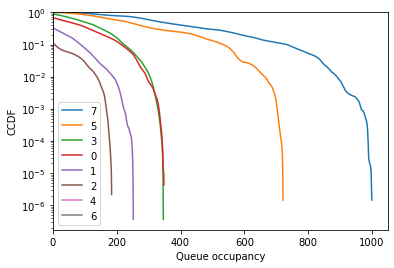

In [7]:
fig = tadpole.simulator.show_ccdf(sort=True)

Node 7 overflowed, while node 5 was not in a good shape either.

This can also be showed with average queue sizes:

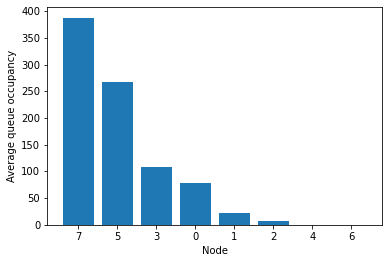

In [8]:
fig = tadpole.simulator.show_average_queues(sort=True)

Let's change the arrival rates to have something nicer.

In [9]:
tadpole.rates = [1, 1, 1, 1, 2, 2, 2, 1]

We can see that it works!

In [10]:
tadpole.run('fcfm', number_events=10000000)

True

In [11]:
tadpole.show_flow()

We can see that the queues are much more tight!

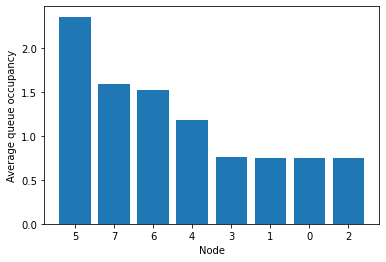

In [12]:
fig = tadpole.simulator.show_average_queues(sort=True)

Note that the average queue can be converted in an average waiting time.

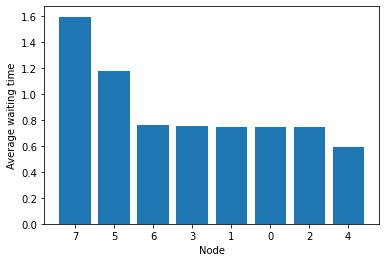

In [13]:
fig = tadpole.simulator.show_average_queues(sort=True, as_time=True)

### Nonjective

Consider the following tadpole:

In [14]:
tadpole = sm.Tadpole(rates='uniform', m=4)

It is bipartite and does not verify the stability condition NCond (even bipartite NCond), so all solution break the conservation law.

Simulation fails:

In [15]:
tadpole.run('fcfm', number_events=10000000, max_queue=100000)

False

In [16]:
tadpole.show_flow()

Nodes 0, 2, and 4 are in limbo.

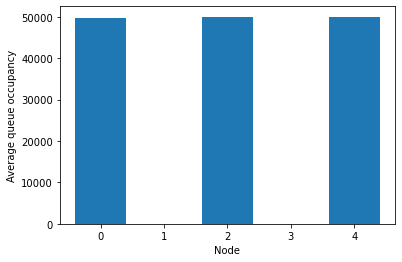

In [17]:
fig = tadpole.simulator.show_average_queues()

Let's change the arrival rates to have bipartite NCond (which is not non-bipartite NCond).

In [18]:
tadpole.rates = [1, 1, 1, 2, 1]

In [19]:
tadpole.run('fcfm', number_events=1000000)

True

We can see that it works! FCFM seems to stabilizes even if NCond is not met.

In [20]:
tadpole.show_flow()

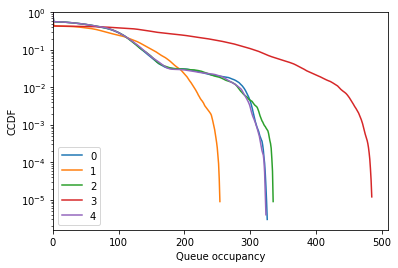

In [21]:
fig = tadpole.simulator.show_ccdf()

Hum, the queues are quite high. Maybe we didn't wait long enough?

In [22]:
tadpole.run('fcfm', number_events=10000000)

False

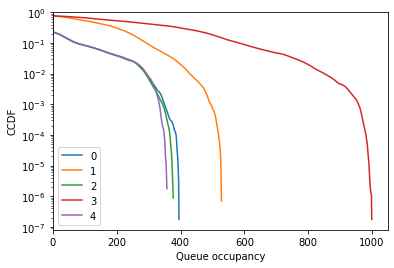

In [23]:
fig = tadpole.simulator.show_ccdf()

Not so stable after all... This is not surprising because of the random walk between left and right nodes, which forces queues of arbitrary size if one waits long enough.

## Diamond

Consider the following:

In [24]:
diamond = sm.CycleChain(tol=1e-4)
ϵ = 0.2
diamond.rates = [2, 2+ϵ, 1+ϵ, 1]

Try fcfm

In [25]:
diamond.run('fcfm', number_events=10000000)

True

In [26]:
diamond.show_flow()

Nodes 0 and 3 are non-empty most of the time.

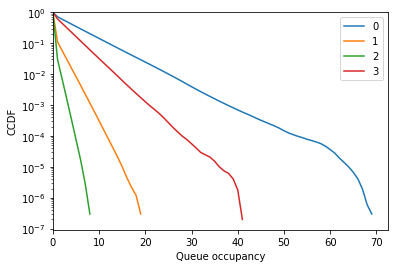

In [27]:
fig = diamond.simulator.show_ccdf()

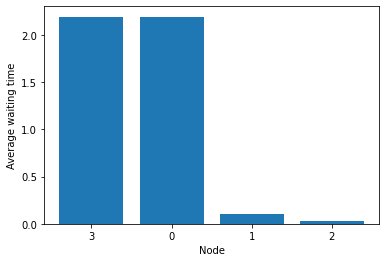

In [28]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

Try random node (we use a seed to have a True result; in practice, random node is highly borderline in this example and overflows relatively often).

In [29]:
diamond.run('random_node', number_events=10000000, seed=42)

True

In [30]:
diamond.show_flow()

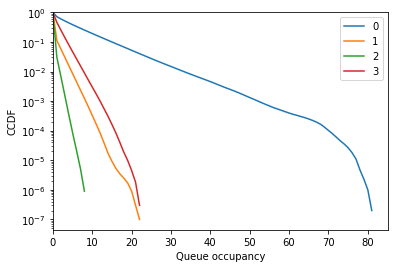

In [31]:
fig = diamond.simulator.show_ccdf()

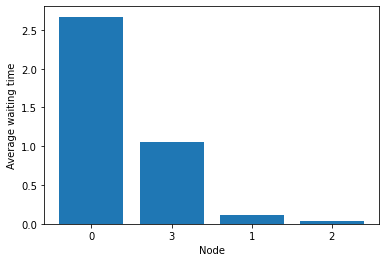

In [32]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

Try random item.

In [33]:
diamond.run('random_item', number_events=10000000)

True

In [34]:
diamond.show_flow()

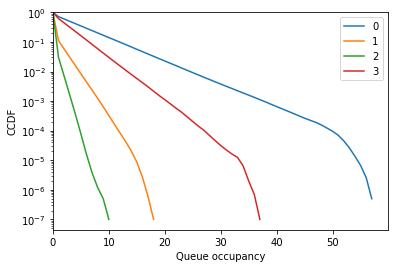

In [35]:
fig = diamond.simulator.show_ccdf()

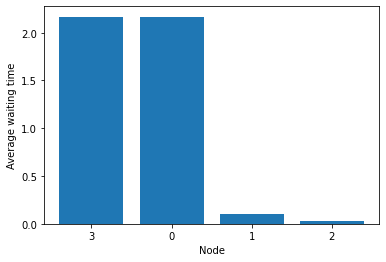

In [36]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

### Trying to reach an extreme feasible solution with a greedy policy

Now we would like to have a greedy policy that tries to move on towards the extreme feasible solutions. Sadly, no such policy exists (cf https://hal.archives-ouvertes.fr/hal-03502084).

Yet, we can try to approach them with priority-based greedy selection. First, look at the extreme points (vertices).

In [37]:
for i in range(len(diamond.vertices)):
    diamond.show_vertex(i)

We can see that the first vertex prioritizes edges 1 and 3, while the second one prioritizes edges 0 and 4. Let us see what happens if one uses these priorities in a greedy policy.

In [38]:
diamond.run('priority', weights=[0, 1, 0, 1, 0], number_events=10000000)
diamond.show_flow()

In [39]:
diamond.run('priority', weights=[1, 0, 0, 0, 1], number_events=10000000)
diamond.show_flow()

Not bad, but not perfect. To reach a vertex, we may need to use a semi-greedy policy.

### Trying to reach an extreme feasible solution with a semi-greedy policy

In [40]:
diamond.vertices

[{'kernel_coordinates': array([-0.3347552]),
  'edge_coordinates': array([0.99740608, 1.00164032, 0.19934016, 1.0016128 , 0.        ]),
  'null_edges': [4],
  'bijective': True},
 {'kernel_coordinates': array([0.6668576]),
  'edge_coordinates': array([1.99901888, 0.        , 0.19934016, 0.        , 1.0016128 ]),
  'null_edges': [1, 3],
  'bijective': False}]

The first kernel is bijective, we just need to forbid the null edge.

In [41]:
diamond.run('semi_greedy', forbidden_edges=diamond.vertices[0]['null_edges'], number_events=10000000)

True

In [42]:
diamond.show_flow()

We can check that the matching rate on edge 4 is 0.

In [43]:
diamond.simulation

array([1.000128  , 1.000912  , 0.198784  , 1.00017152, 0.        ])

No noticeable impact on the performance.

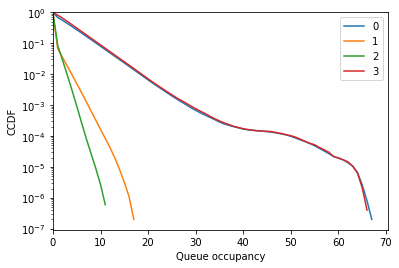

In [44]:
fig = diamond.simulator.show_ccdf()

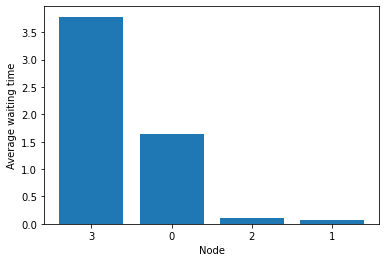

In [45]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

Now we try on the second kernel.

In [46]:
diamond.run('semi_greedy', forbidden_edges=diamond.vertices[1]['null_edges'], number_events=10000000)

False

In [47]:
diamond.show_flow()

So this is unstable but the the matching rate on edges 1 and 3 is 0.

In [48]:
diamond.simulation

array([1.99512693, 0.        , 0.20336808, 0.        , 0.99846916])

Performance is bad, as the vertex is bipartite.

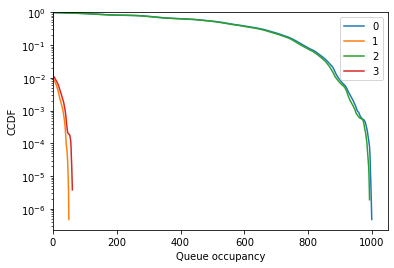

In [49]:
fig = diamond.simulator.show_ccdf()

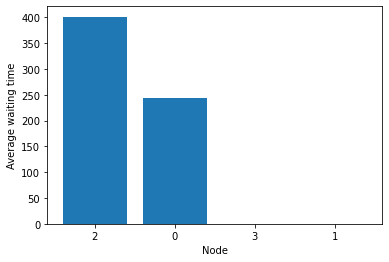

In [50]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

The solution in that case is to use a semi-greedy policy with threshold.

In [51]:
diamond.run('semi_greedy', forbidden_edges=diamond.vertices[1]['null_edges'], threshold=500, number_events=10000000)

True

In [52]:
diamond.show_flow()

So this is stable with a limited matching rate on edges 1 and 3.

In [53]:
diamond.simulation

array([1.99940288e+00, 6.00320000e-04, 2.01430400e-01, 0.00000000e+00,
       9.98465280e-01])

Performance is controlled by the threshold.

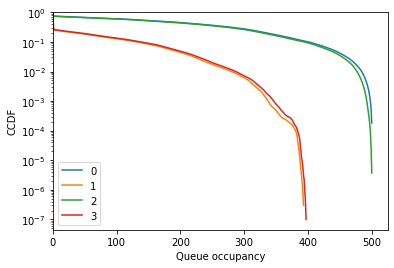

In [54]:
fig = diamond.simulator.show_ccdf()

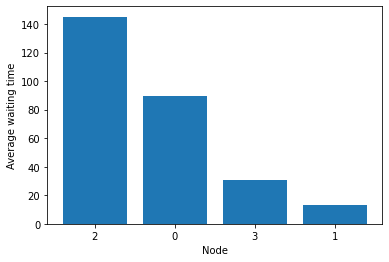

In [55]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

## Fish

The purpose of this example is to show a case where a family of greedy with priorities can asymptotically reach the vertices.

In [56]:
fish = sm.KayakPaddle(l=0, m=4, names=[str(i) for i in range(1, 7)], rates = [4, 4, 3, 2, 3, 2])
fish.show_graph()

Look at the vertices:

In [57]:
for i in range(len(fish.vertices)):
    fish.show_vertex(i, disp_rates=False)

Let us try to nullify the edge between 3 and 6 with adapted priorities. As this may be unstable, let us pick a large max queue.

In [58]:
weights = [0, 2, 2, 1, 0, 0, 1]
fish.run('priority', weights=weights, number_events=10000000, max_queue=1000000)

True

In [59]:
fish.show_flow(disp_rates=False)

So we managed to almost nullify the edge at the price of making node 4 unstable (it cannot check the conservation law). This can be addressed by using a threshold above which the policy is altered.

In [60]:
counterweights = [0, 1, 1, 2, 0, 0, 2]

In [61]:
fish.run('priority', weights=weights, number_events=10000000, threshold=500, counterweights=counterweights)

True

In [62]:
fish.show_flow(disp_rates=False)

And that's it! The threshold controls the trade-off between the size of queue 4 and the nullity of edge (3, 6).

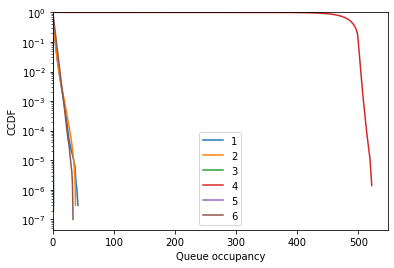

In [63]:
fig = fish.simulator.show_ccdf()

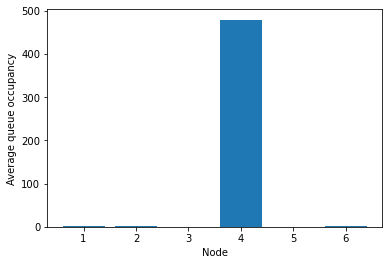

In [64]:
fig = fish.simulator.show_average_queues()

In [65]:
fish.run('priority', weights=weights, number_events=10000000, threshold=10, counterweights=counterweights)

True

In [66]:
fish.show_flow(disp_rates=False)

And that's it! The threshold controls the trade-off between the size of queue 4 and the nullity of edge (3, 6).

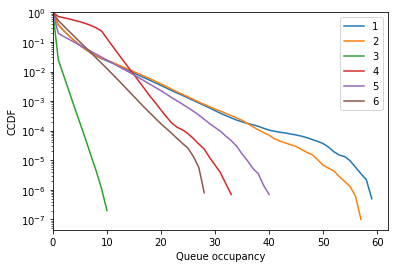

In [67]:
fig = fish.simulator.show_ccdf()

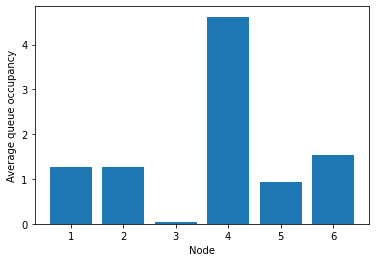

In [68]:
fig = fish.simulator.show_average_queues()

## Reaching a highly degenerated vertex

The following model has *very injective* vertices.

In [69]:
import numpy as np
codomino = sm.Codomino(rates=[2, 4, 2, 2, 4, 2])
codomino.base_flow = np.array([1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0])
codomino.vertices

[{'kernel_coordinates': array([-1.,  1.]),
  'edge_coordinates': array([2., 0., 0., 2., 2., 0., 0., 2.]),
  'null_edges': [1, 2, 5, 6],
  'bijective': False},
 {'kernel_coordinates': array([-1., -1.]),
  'edge_coordinates': array([0., 2., 0., 4., 0., 0., 2., 0.]),
  'null_edges': [0, 2, 4, 5, 7],
  'bijective': False},
 {'kernel_coordinates': array([1., 1.]),
  'edge_coordinates': array([2., 0., 2., 0., 0., 2., 0., 2.]),
  'null_edges': [1, 3, 4, 6],
  'bijective': False}]

In particular the second vertex is made of three unconnected pairs:

In [70]:
codomino.show_vertex(1)

Let try to reach it with a semi-greedy policy without threshold.

In [71]:
codomino.run('semi_greedy', forbidden_edges=codomino.vertices[1]['null_edges'], number_events=10000000, max_queue=100000)

True

In [72]:
codomino.show_flow()

As this is a pure semi-greedy, the desired edges are indeed null.

In [73]:
codomino.simulation

array([0.       , 1.9983344, 0.       , 3.9980432, 0.       , 0.       ,
       1.9988784, 0.       ])

But performance terrible!

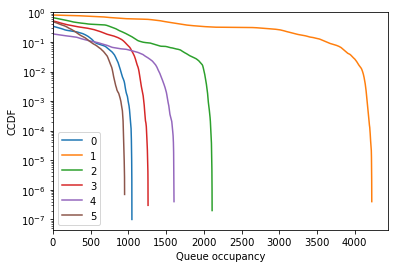

In [74]:
fig = codomino.simulator.show_ccdf()

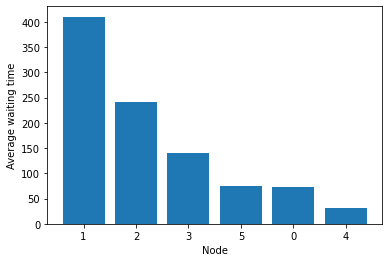

In [75]:
fig = codomino.simulator.show_average_queues(sort=True, as_time=True)

The solution in that case is to use a semi-greedy policy with threshold.

In [76]:
codomino.run('semi_greedy', forbidden_edges=codomino.vertices[1]['null_edges'], threshold=900, number_events=10000000)

True

In [77]:
codomino.show_flow()

So this is stable with a limited matching rate on forbidden edges.

In [78]:
codomino.simulation

array([2.3296000e-03, 1.9980880e+00, 5.7600000e-04, 3.9953488e+00,
       2.4000000e-05, 2.2704000e-03, 1.9952416e+00, 5.2704000e-03])

Performance is controlled by the threshold.

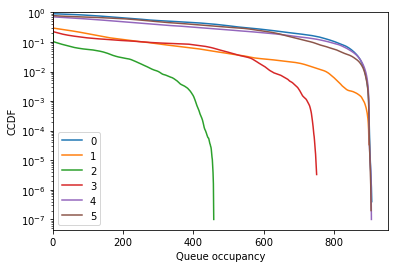

In [79]:
fig = codomino.simulator.show_ccdf()

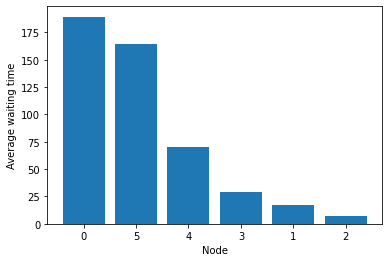

In [80]:
fig = codomino.simulator.show_average_queues(sort=True, as_time=True)

In [81]:
codomino.run('semi_greedy', forbidden_edges=codomino.vertices[1]['null_edges'], threshold=50, number_events=10000000)

True

In [82]:
codomino.show_flow()

In [83]:
codomino.simulation

array([0.0476176, 1.9534336, 0.034488 , 3.9177056, 0.0123184, 0.033208 ,
       1.9525792, 0.0485968])

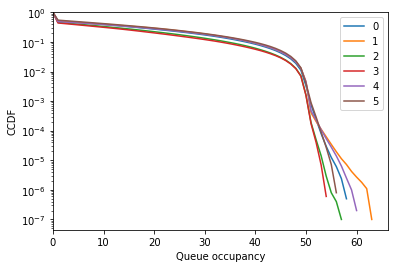

In [84]:
fig = codomino.simulator.show_ccdf()

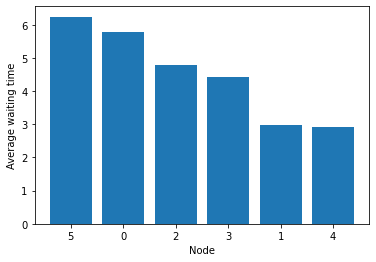

In [85]:
fig = codomino.simulator.show_average_queues(sort=True, as_time=True)